In [1]:
import sys
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
sys.path.append('..')
from utils import encode_targets, decode_targets, draw_boxes_cv2, imshow, get_anchors, change_box_format
from model.retinanet import RetinaNet
from model.loss import LossV2

In [3]:
INPUT_SHAPE = 800
BATCH_SIZE = 2
N_CLASSES = 20

In [4]:
dataset = tfds.load('voc2007', shuffle_files=False)

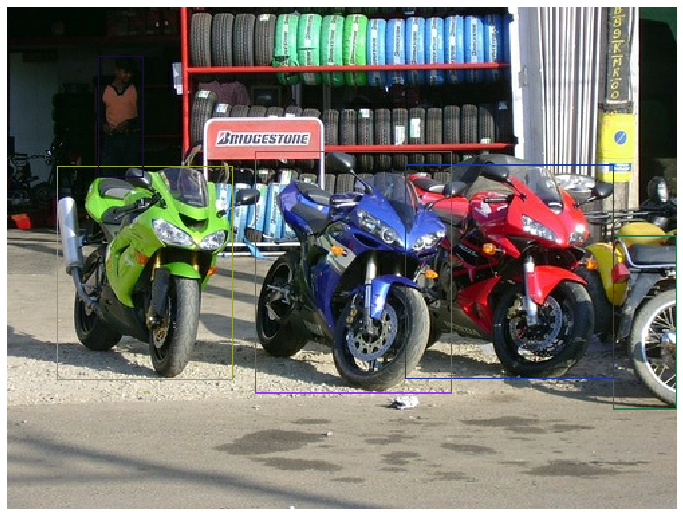

In [5]:
for example in dataset['train'].take(1):
    image = tf.image.convert_image_dtype(example['image'], dtype=tf.float32)
    boxes = tf.cast(example['objects']['bbox'], dtype=tf.float32)
    labels = example['objects']['label']
    color = tf.random.uniform(shape=[boxes.shape[0], 3],dtype=tf.float32)
    viz_image = tf.image.draw_bounding_boxes(image[None, ...], boxes[None, ...], color)[0]
imshow(viz_image)

In [6]:
@tf.function
def flip_data(image, boxes, w):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack([
            w - boxes[:, 2],
            boxes[:, 1],
            w - boxes[:, 0],
            boxes[:, 3]
        ], axis=-1)
    return image, boxes

def load_data(input_shape):
    h, w = input_shape, input_shape
    @tf.function
    def load_data_(example, input_shape=input_shape):
        image = tf.cast(example['image'], dtype=tf.float32)
        boxes_ = example['objects']['bbox']
        class_ids = tf.expand_dims(tf.cast(example['objects']['label'], dtype=tf.float32), axis=-1)
        image = tf.image.resize(image, size=[h, w])
        # convert y1x1y2x2 -> x1y1x2y2
        boxes = tf.stack([
            tf.clip_by_value(boxes_[:, 1] * w, 0, w),
            tf.clip_by_value(boxes_[:, 0] * h, 0, h),
            tf.clip_by_value(boxes_[:, 3] * w, 0, w),
            tf.clip_by_value(boxes_[:, 2] * h, 0, h)
        ], axis=-1)
        image, boxes = flip_data(image, boxes, w)
        label = tf.concat([boxes, class_ids], axis=-1)
        targets = encode_targets(label, input_shape=input_shape)
        return image, targets
    return load_data_

In [7]:
train_dataset = dataset['train'].map(load_data(input_shape=INPUT_SHAPE), num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
train_dataset

<PrefetchDataset shapes: ((2, 800, 800, 3), ((2, 119745), (2, 119745, 4), (2, 119745), (2, 119745))), types: (tf.float32, (tf.int32, tf.float32, tf.bool, tf.bool))>

## Check encoding and decoding

[[636  81 689 273]
 [529 256 739 595]
 [  0 366  75 642]
 [ 75 253 323 593]
 [268 232 502 616]]
[14 13 13 13 13]
[1. 1. 1. 1. 1.]


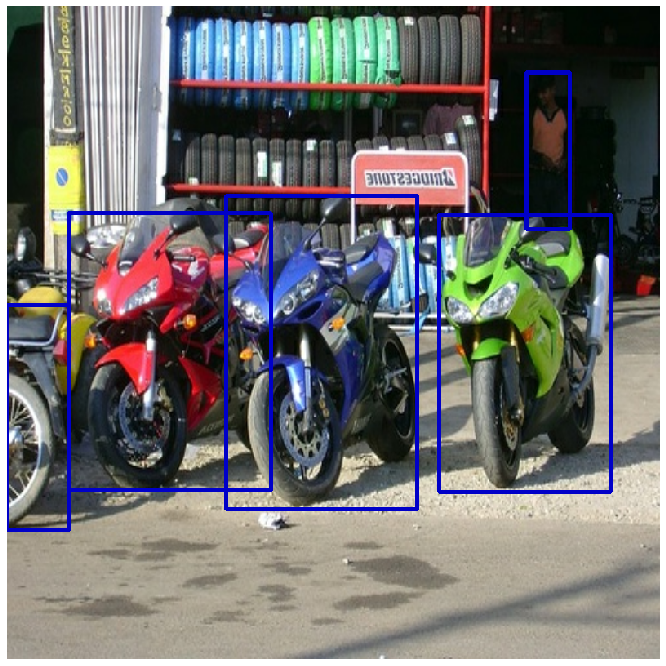

In [11]:
i = 0
for batch in train_dataset.take(1):
    break
image = batch[0][i]
cls_targets, reg_targets, _, _ = batch[1]
classification_outputs = tf.one_hot(cls_targets[i], depth=N_CLASSES + 1)[:, 1:]
regression_outputs = reg_targets[i]

scale_factors = tf.constant([5.0, 5.0, 5.0, 5.0])
anchors = get_anchors(input_shape=INPUT_SHAPE, tensor=True)
class_ids = tf.argmax(classification_outputs, axis=-1)
confidence_scores = tf.reduce_max(classification_outputs, axis=-1)
regression_outputs = regression_outputs / scale_factors
boxes = tf.concat([(regression_outputs[:, :2] * anchors[:, 2:] + anchors[:, :2]),
                   tf.math.exp(regression_outputs[:, 2:]) * anchors[:, 2:]
                   ], axis=-1)
boxes = change_box_format(boxes, return_format='x1y1x2y2')

nms_indices = tf.image.non_max_suppression(boxes,
                                           confidence_scores,
                                           score_threshold=0.05,
                                           iou_threshold=0.5,
                                           max_output_size=200)
final_class_ids = tf.gather(class_ids, nms_indices)
final_scores = tf.gather(confidence_scores, nms_indices)
final_boxes = tf.cast(tf.gather(boxes, nms_indices), dtype=tf.int32)

matched_anchors = tf.gather(anchors, tf.where(confidence_scores > 0.05)[:, 0])
matched_anchors = tf.cast(change_box_format(matched_anchors, return_format='x1y1x2y2'),
                      dtype=tf.int32)
img = draw_boxes_cv2(image, boxes)
imshow(img)
print(final_boxes.numpy())
print(final_class_ids.numpy())
print(final_scores.numpy())